In [1]:
# jag version
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import os

In [2]:
#Path of the file with the data of particles
path = r'/home/user/Documents/BUAP/Estancia/CosmicRayReco/MCAnalysis/ClusterAnalysis/Data'
os.chdir(path)
#os.chdir('/Users/JAG/progs/buap/oliver')

In [3]:
#File with summary of Showers
Showers = pd.read_csv(r'DAT000006_1k_showers.txt',delimiter='\t')

In [4]:
#Statistics of the data frame with summary of showers 
#Showers.describe()
Showers
#Showers[Showers['NShow']==1]

,NShow,Energy,ZFInt,ZhAng,AzAng,NParticles
0,1,1000,21.8589,20.93290,175.38100,240
1,2,1000,21.6378,19.03420,-9.29939,51
2,3,1000,22.9038,16.56260,164.26400,246
3,4,1000,13.4947,20.75230,155.63300,32
4,5,1000,19.9795,8.44973,48.14700,49
...,...,...,...,...,...,...
995,996,1000,34.1608,11.05530,-12.91870,19
996,997,1000,59.5770,22.62960,27.18390,9
997,998,1000,11.4008,12.71430,174.38900,62
998,999,1000,17.5343,25.34680,-81.59460,44


In [5]:
#File with information of all particles at observation level
Particles = pd.read_csv('DAT000006_1k_particles.txt',delimiter='\t')

In [6]:
# Run summary
Energies = {'E1': 9, 'E2': 11, 'E3': 14, 'E4': 18, 'E5': 55, 'E6':70}
Run = {'SCod': 'Corsika-77500','Mass':[1],'Lab': ['BUAP'], 'NShows':[1000], 'EInf': Energies['E1'] , 'ESup': Energies['E2'], 'AAInf':[0], 'AASup':[25]} 
Run = pd.DataFrame(Run)
# Quizas se podrian incluir en RUN otros parametros usados en la simulacion:
# - altura, cortes en energia, campo magnetico, etc. para poder reproducir a ampliar la simulacion en caso necesrio

In [7]:
Run

,SCod,Mass,Lab,NShows,EInf,ESup,AAInf,AASup
0,Corsika-77500,1,BUAP,1000,9,11,0,25


In [8]:
# Define local particles codes for labeling clusters
# Particle Corsika PID       P. Code
# Gamma        1              1
# Electrons    2,3            1000
# Muons        5,6            100000
# Pions        8,9            50000000
# Protons      14             10000000
# Neutrons     13             100000000
nop   = -999.
gam   = 1.
ele   = 1000.
mu    = 100000.
prn   = 10000000.
ntn   = 100000000. 
pi    = 500000000.

pmap   = {1.:gam,2.:ele,3.:ele,5.:mu,6.:mu,8.:pi, 9.:pi, 13.:ntn, 14.:prn}
#pmap   = {'1.':'gam','2.':'ele','3.':'ele','5.':'mu','6.':'mu','8.':'pi','9.':'pi', '13.':'ntn', '14.':'prn'}
#pid    = [1., 2., 3., 5., 6., 8., 9., 13., 14.]
#zipped = list(zip(pid,pcode))
#pcode  = pd.DataFrame(zipped, columns=['pid', 'pcode'])
Particles['R'] = np.sqrt(Particles['X']**2 + Particles['Y']**2)
Particles['PCode'] = Particles['PId'].map(pmap)

In [9]:
#Particles.describe()
Particles['PCode']
#Particles['PId']

0             1.0
1             1.0
2             1.0
3             1.0
4             1.0
           ...   
76243    100000.0
76244      1000.0
76245    100000.0
76246    100000.0
76247    100000.0
Name: PCode, Length: 76248, dtype: float64

In [10]:
# Detector layout
det_s_x = 1.0 # detector size in x axis (m)
det_s_y = 1.0 # detector size in y axis (m)

In [11]:
#The values in the 'DetMdx' and 'DetMdy' columns will be replaced by the rounded values 
#of the positions of the particles, this will define the position of the cell
#
Particles['DetX'] = np.floor(Particles['X']/det_s_x) + det_s_x/2
Particles['DetY'] = np.floor(Particles['Y']/det_s_x) + det_s_y/2
#
Particles['PartX'] = 1000 * (Particles['X'] - Particles['DetX']) # mm
Particles['PartY'] = 1000 * (Particles['Y'] - Particles['DetY']) # mm
#Add a new column which will contain the number of cluster 
Particles['NClst'] = 0

In [12]:
Particles.head()

,NShow,PId,X,Y,T,Px,Py,Pz,PSq,Ene,ZhA,AzA,R,PCode,DetX,DetY,PartX,PartY,NClst
0,1,1,202.8570,-52.80860,70347.8,-0.014051,0.000221,0.052103,0.002912,0.053965,15.0941,179.100,209.618011,1.0,202.5,-52.5,357.0,-308.60,0
1,1,1,43.9967,-18.30410,70512.6,-0.182562,0.015446,0.487750,0.271468,0.521026,20.5877,175.164,47.652384,1.0,43.5,-18.5,496.7,195.90,0
2,1,1,26.9723,-5.68421,70534.3,-0.126190,0.013492,0.323988,0.121074,0.347957,21.3907,173.897,27.564746,1.0,26.5,-5.5,472.3,-184.21,0
3,1,1,33.2305,3.98663,70528.2,-0.020200,0.002715,0.052752,0.003198,0.056553,21.1248,172.344,33.468782,1.0,33.5,3.5,-269.5,486.63,0
4,1,1,79.4011,13.43910,70477.4,-0.018291,0.003078,0.052332,0.003083,0.055522,19.5160,170.449,80.530392,1.0,79.5,13.5,-98.9,-60.90,0


In [14]:
def add_Particle(Cluster, Particles_in_det, iclust):
    # For one particle clusters
    if(len(Particles_in_det) == 1):
        Pcles_in_clust = Particles_in_det[Particles_in_det['NClst'] == iclust]
        ClsIdC = Pcles_in_clust["PCode"].tolist()[0]
        NpartC = Pcles_in_clust.shape[0]
        NGamC  = Pcles_in_clust[Pcles_in_clust['PCode']==1.].shape[0]
        NEleC  = Pcles_in_clust[Pcles_in_clust['PCode']==1000.].shape[0]
        NMuCl  = Pcles_in_clust[Pcles_in_clust['PCode']==100000.].shape[0]
        XmClst = Pcles_in_clust["X"].tolist()[0]
        YmClst = Pcles_in_clust["Y"].tolist()[0]
        RmClst = Pcles_in_clust["R"].tolist()[0]
        SigRCl = 0
        TmClst = Pcles_in_clust["T"].tolist()[0]
        dTClst = Pcles_in_clust["T"].max()-Pcles_in_clust["T"].min()
        sTClst = 0
        FstPID = ClsIdC
        FstPCX = Pcles_in_clust["Px"].tolist()[0]
        FstPCY = Pcles_in_clust["Py"].tolist()[0]
        FstPCT = Pcles_in_clust["T"].tolist()[0]
        FstPZh = Pcles_in_clust["ZhA"].tolist()[0]
        FstPAz = Pcles_in_clust["AzA"].tolist()[0]
        FstPPm = np.sqrt(FstPCX**2+FstPCY**2+Pcles_in_clust["Pz"].tolist()[0]**2)
        LstPID = FstPID
        LstPCX = FstPCX
        LstPCY = FstPCY
        LstPCT = FstPCT
        LstPZh = FstPZh
        LstPAz = FstPAz
        LstPPm = FstPPm

    # For clusters with more than 1 particle
    if(len(Particles_in_det) > 1):
        # Calculate variables and fill the Cluster dataframe
        Pcles_in_clust  = Particles_in_det[Particles_in_det['NClst'] == iclust]
        FirstPart = Pcles_in_clust[Pcles_in_clust['T'] == Pcles_in_clust["T"].min()]
        LastPart  = Pcles_in_clust[Pcles_in_clust['T'] == Pcles_in_clust["T"].max()]
        ClustStats_mean = Pcles_in_clust[["X","Y","R","T"]].mean()
        ClustStats_std  = Pcles_in_clust[["X","Y","R", "T"]].std()
        ClsIdC = Pcles_in_clust["PCode"].sum()
        NpartC = Pcles_in_clust.shape[0]
        NGamC = Pcles_in_clust[Pcles_in_clust['PCode']==1.].shape[0]
        NEleC = Pcles_in_clust[Pcles_in_clust['PCode']==1000.].shape[0]
        NMuCl = Pcles_in_clust[Pcles_in_clust['PCode']==100000.].shape[0]
        XmClst = ClustStats_mean["X"]
        YmClst = ClustStats_mean["Y"]
        RmClst = ClustStats_mean["R"]
        SigRCl = ClustStats_std["R"]
        TmClst = ClustStats_mean["T"]
        dTClst = Pcles_in_clust["T"].max()-Pcles_in_clust["T"].min()
        sTClst = ClustStats_std["T"]
        FstPID = FirstPart["PCode"].tolist()[0]
        FstPCX = FirstPart["Px"].tolist()[0]
        FstPCY = FirstPart["Py"].tolist()[0]
        FstPCT = FirstPart["T"].tolist()[0]
        FstPZh = FirstPart["ZhA"].tolist()[0]
        FstPAz = FirstPart["AzA"].tolist()[0]
        FstPPm = np.sqrt(FirstPart["Px"].tolist()[0]**2+FirstPart["Py"].tolist()[0]**2+FirstPart["Pz"].tolist()[0]**2)
        LstPID = LastPart["PCode"].tolist()[0]
        LstPCX = LastPart["Px"].tolist()[0]
        LstPCY = LastPart["Py"].tolist()[0]
        LstPCT = LastPart["T"].tolist()[0]
        LstPZh = LastPart["ZhA"].tolist()[0]
        LstPAz = LastPart["AzA"].tolist()[0]
        LstPPm = np.sqrt(LastPart["Px"].tolist()[0]**2+LastPart["Py"].tolist()[0]**2+LastPart["Pz"].tolist()[0]**2)
    #
    
    cluster = [ishow, iclust, ClsIdC, NpartC, NGamC, NEleC, NMuCl,
                   XmClst, YmClst, RmClst, SigRCl,
                   TmClst, dTClst, sTClst,
                   FstPID, FstPCX, FstPCY, FstPCT, FstPZh, FstPAz, FstPPm,
                   LstPID, LstPCX, LstPCY, LstPCT, LstPZh, LstPAz, LstPPm]

    Cluster.loc[len(Cluster.index)] = cluster # Fill new row

    return Cluster, iclust        


In [26]:
def find_Cluster(Cluster, Particle, iclust, ishow):
    # Find clusters of Particle in a shower
    # iclust:  index of the cluster
    # Particle:  analyzed Particle in a shower
    # Cluster: finded Cluster
    
    #ishow = 0
    X_Det = Particle['DetX'].tolist()
    Y_Det = Particle['DetY'].tolist()
    
    detector_set = set() # Create an empty set

    # Iterate over the detector coordinates using zip
    for det_x,det_y  in zip(X_Det, Y_Det):
        det_xy = (det_x, det_y)
        #VarClust = []
        # Check if the detector cell is already in the set
        if det_xy not in detector_set:
            detector_set.add(det_xy) #  Add the detector to the set
            
            Particle_in_detxy = Particle.index[ (Particle['DetX'] == det_x) & (Particle['DetY'] == det_y) ].tolist()
            
        
            for ipart in range(len(Particle_in_detxy)):
                Particle.at[Particle_in_detxy[ipart],'NClst'] = iclust
        
                # Add to one particle, accesing to the information in the Particle df
            
            Cluster, iclust = add_Particle(Cluster, Particle, iclust) 
            
            ### El error era que a la función add_Particle le pasabas Particle_in_detxy que es una lista
            ### con los índices de las partículas del shower que están en el i-ésimo cluster
            ### esta función debe recibir el data frame de las partículas.
            
            iclust = iclust+1 # Next Cluster
    
    return Cluster, Particle, iclust

In [27]:
%%time
# Define the dataframe for cluster info.
Clusters = {"iClst": [],'ClsId': [], 'nPartCl': [], "nGamCl": [], "nEleCl": [],"nMuCl": [],
            "XmClst": [], "YmClst": [], "RmClst": [], "SigRCl": [],
            "TmClst": [], "dTClst": [], "sTClst": [],
            "FstPID": [], "FstPCX": [], "FstPCY": [], "FstPCT": [], "FstPZh": [], "FstPAz": [], "FstPPm": [],
            "LstPID": [], "LstPCX": [], "LstPCY": [], "LstPCT": [], "LstPZh": [], "LstPAz": [], "LstPPm": []
            } 
Clusters = pd.DataFrame(Clusters)
Clusters.insert(0, 'iShow', 0) 
#
icluster   = 1                               # Cluster counter
n = 2
#for ishow in range(n):
showers_list = Showers['NShow'].tolist()
for ishow in showers_list:   # Run over all the showers
    #
    Particles_in_shower = Particles[Particles['NShow'] == ishow] # Particle in current shower
    #
    Clusters, Particle, icluster = find_Cluster(Clusters, Particles_in_shower, icluster, ishow) 
    Particles.loc[Particles['NShow']==ishow, :] = Particle
    #

CPU times: user 24min 45s, sys: 1min 44s, total: 26min 30s
Wall time: 26min 30s


In [28]:
Particles[Particles["NClst"]==0]

,NShow,PId,X,Y,T,Px,Py,Pz,PSq,Ene,ZhA,AzA,R,PCode,DetX,DetY,PartX,PartY,NClst


In [29]:
#Clusters
#Clusters[Clusters['nPartCl']==4]
#Clusters[(Clusters["iShower"]==1) & (Clusters['NpartC']>1)]
#Particles.loc[0,:]
Particle

,NShow,PId,X,Y,T,Px,Py,Pz,PSq,Ene,ZhA,AzA,R,PCode,DetX,DetY,PartX,PartY,NClst
76221,1000,5,-46.1155,-648.6110,66890.0,-5.706860,-2.569200,17.855700,357.996000,18.815400,19.3158,-155.763,650.248313,100000.0,-46.5,-648.5,384.5,-111.0,72155
76222,1000,6,571.3900,174.2830,65991.7,-4.645100,-1.563710,16.651100,301.281000,17.252100,16.4017,-161.395,597.378520,100000.0,571.5,174.5,-110.0,-217.0,72156
76223,1000,5,-267.2520,891.8230,66672.0,-0.750562,-0.136215,2.468880,6.677260,2.480540,17.1699,-169.714,931.005851,100000.0,-267.5,891.5,248.0,323.0,72157
76224,1000,5,-516.1690,-686.7440,67558.9,-0.274096,-0.137893,0.707949,0.595334,0.673121,23.4321,-153.294,859.097060,100000.0,-516.5,-686.5,331.0,-244.0,72158
76225,1000,5,-587.6060,94.4424,67223.5,-0.586870,-0.225347,1.720320,3.354710,1.728970,20.0735,-158.994,595.147190,100000.0,-587.5,94.5,-106.0,-57.6,72159
76226,1000,5,-616.9310,-1868.1600,68426.6,-0.278086,-0.283596,0.760313,0.735834,0.758632,27.5826,-134.438,1967.390567,100000.0,-616.5,-1868.5,-431.0,340.0,72160
76227,1000,5,-85.2505,-2729.8600,68384.4,-0.439375,-0.459587,1.485280,2.610330,1.513440,23.1749,-133.712,2731.190815,100000.0,-85.5,-2729.5,249.5,-360.0,72161
76228,1000,6,125.6440,142.4710,66420.2,-3.291870,-0.892408,10.768500,127.593000,11.190600,17.5745,-164.832,189.958944,100000.0,125.5,142.5,144.0,-29.0,72162
76229,1000,5,-886.9430,-390.6920,67921.7,-0.192744,-0.093256,0.508924,0.304850,0.456493,22.8180,-154.181,969.179098,100000.0,-886.5,-390.5,-443.0,-192.0,72163
76230,1000,5,340.3920,284.3940,66171.4,-3.517080,-1.163760,12.060300,159.176000,12.511300,17.0756,-161.691,443.561338,100000.0,340.5,284.5,-108.0,-106.0,72164


In [30]:
#Particles
# Check if there are particles that are not counted
Particles[Particles["NClst"]==0]

,NShow,PId,X,Y,T,Px,Py,Pz,PSq,Ene,ZhA,AzA,R,PCode,DetX,DetY,PartX,PartY,NClst


In [31]:
Clusters
#Clusters[Clusters['NClst']==1]

,iShow,iClst,ClsId,nPartCl,nGamCl,nEleCl,nMuCl,XmClst,YmClst,RmClst,...,FstPZh,FstPAz,FstPPm,LstPID,LstPCX,LstPCY,LstPCT,LstPZh,LstPAz,LstPPm
0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,202.8570,-52.80860,209.618011,...,15.0941,179.100,0.053965,1.0,-0.014051,0.000221,70347.8,15.0941,179.100,0.053965
1,1.0,2.0,1.0,1.0,1.0,0.0,0.0,43.9967,-18.30410,47.652384,...,20.5877,175.164,0.521025,1.0,-0.182562,0.015446,70512.6,20.5877,175.164,0.521025
2,1.0,3.0,1.0,1.0,1.0,0.0,0.0,26.9723,-5.68421,27.564746,...,21.3907,173.897,0.347957,1.0,-0.126190,0.013492,70534.3,21.3907,173.897,0.347957
3,1.0,4.0,1.0,1.0,1.0,0.0,0.0,33.2305,3.98663,33.468782,...,21.1248,172.344,0.056553,1.0,-0.020200,0.002715,70528.2,21.1248,172.344,0.056553
4,1.0,5.0,1.0,1.0,1.0,0.0,0.0,79.4011,13.43910,80.530392,...,19.5160,170.449,0.055522,1.0,-0.018291,0.003078,70477.4,19.5160,170.449,0.055522
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72176,1000.0,72177.0,100000.0,1.0,0.0,0.0,1.0,60.9239,15.21820,62.795822,...,18.2568,-160.998,112.243174,100000.0,-33.247300,-11.449000,66522.0,18.2568,-160.998,112.243174
72177,1000.0,72178.0,1000.0,1.0,0.0,1.0,0.0,-356.6540,360.43600,507.066254,...,18.5018,-147.681,0.055574,1000.0,-0.014904,-0.009428,66859.6,18.5018,-147.681,0.055574
72178,1000.0,72179.0,100000.0,1.0,0.0,0.0,1.0,484.7020,354.32500,600.401728,...,18.2758,-161.219,3.728229,100000.0,-1.106890,-0.376404,66030.5,18.2758,-161.219,3.728229
72179,1000.0,72180.0,100000.0,1.0,0.0,0.0,1.0,60.6589,-90.33680,108.812865,...,18.4427,-159.359,31.711704,100000.0,-9.388220,-3.536470,66559.4,18.4427,-159.359,31.711704


In [32]:
# Number of the cluster with the maximum number of particles
df_sn = Particles[Particles["NClst"]!=0]
Max_ClustId = df_sn["NClst"].value_counts().idxmax()
print(Max_ClustId)

24354


In [33]:
# Summary of the cluster with the maximum number of particles
Particles[Particles["NClst"]==Max_ClustId]

,NShow,PId,X,Y,T,Px,Py,Pz,PSq,Ene,ZhA,AzA,R,PCode,DetX,DetY,PartX,PartY,NClst
25576,328,1,1.97012,15.9225,18025.3,0.017121,0.012351,0.067537,0.005007,0.070760,17.3582,35.8073,16.043920,1.0,1.5,15.5,470.12,422.5,24354
25595,328,1,1.27997,15.5098,18024.6,0.033219,0.021118,0.115938,0.014991,0.122438,18.7536,32.4456,15.562526,1.0,1.5,15.5,-220.03,9.8,24354
25596,328,2,1.27997,15.5085,18024.6,0.136209,0.085286,0.477266,0.253610,0.503086,18.6095,32.0524,15.561231,1000.0,1.5,15.5,-220.03,8.5,24354
25659,328,1,1.87157,15.5438,18025.0,0.017631,0.012707,0.069351,0.005282,0.072677,17.3998,35.7803,15.656069,1.0,1.5,15.5,371.57,43.8,24354
25660,328,1,1.74490,15.5494,18024.9,0.444662,0.321847,1.755030,3.381460,1.838870,17.3680,35.8970,15.646997,1.0,1.5,15.5,244.90,49.4,24354
25661,328,1,1.75018,15.5706,18024.9,0.239785,0.173728,0.946251,0.983070,0.991499,17.3762,35.9240,15.668654,1.0,1.5,15.5,250.18,70.6,24354
25662,328,2,1.91793,15.5637,18025.0,0.790821,0.567981,3.074410,10.400000,3.224390,17.5728,35.6865,15.681429,1000.0,1.5,15.5,417.93,63.7,24354
25663,328,1,1.81122,15.7059,18025.0,0.013336,0.009632,0.052452,0.003022,0.054971,17.4134,35.8380,15.809991,1.0,1.5,15.5,311.22,205.9,24354
25664,328,1,1.83963,15.7272,18025.0,0.095424,0.068919,0.375200,0.154631,0.393231,17.4179,35.8382,15.834426,1.0,1.5,15.5,339.63,227.2,24354
25665,328,1,1.59644,15.7747,18024.9,0.092728,0.067197,0.365548,0.146739,0.383066,17.3943,35.9295,15.855276,1.0,1.5,15.5,96.44,274.7,24354


In [34]:
# Summary of the cluster with the maximum number of particles
Clusters[Clusters["iClst"]==Max_ClustId]

,iShow,iClst,ClsId,nPartCl,nGamCl,nEleCl,nMuCl,XmClst,YmClst,RmClst,...,FstPZh,FstPAz,FstPPm,LstPID,LstPCX,LstPCY,LstPCT,LstPZh,LstPAz,LstPPm
24353,328.0,24354.0,7020.0,27.0,20.0,7.0,0.0,1.757474,15.579659,15.679865,...,18.7536,32.4456,0.122438,1.0,0.017121,0.012351,18025.3,17.3582,35.8073,0.07076


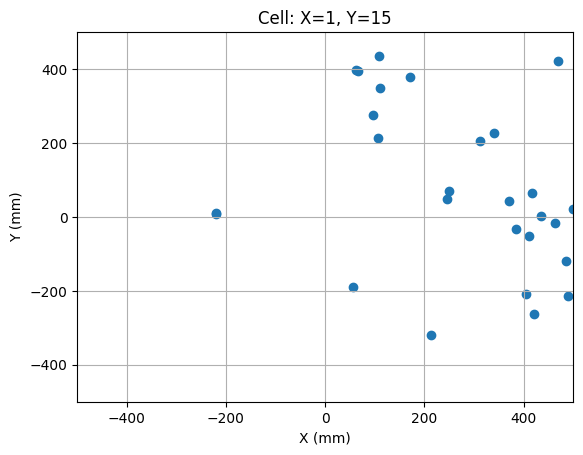

In [35]:
#Plot the cell with the maximum number of particles
cx = Particles.loc[Particles["NClst"]==Max_ClustId,'DetX'].iloc[0]
cy = Particles.loc[Particles["NClst"]==Max_ClustId,'DetY'].iloc[0]
Mx = Particles.loc[Particles["NClst"]==Max_ClustId,'PartX']
My = Particles.loc[Particles["NClst"]==Max_ClustId,'PartY']
plt.scatter(Mx,My)
plt.title('Cell: X=%i, Y=%i'%(cx,cy))
plt.xlabel('X (mm)')
plt.ylabel('Y (mm)')
#Cell for detector of 1 m^2 
plt.axis([-500,500,-500,500])
#Cell for detector of 0.30 x 0.30 m^2
#plt.axis([-150,150,-150,150])
plt.grid(True)